In [1]:
import amplify
import os

# load the model
MODEL = "AMPLIFY_350M"
path = f"../../../data/models/AMPLIFY/{MODEL}/"
config_path = os.path.join(path, "config.yaml")
checkpoint_file = os.path.join(path, "pytorch_model.pt")

model, tokenizer = amplify.AMPLIFY.load(checkpoint_file, config_path)
predictor = amplify.inference.Predictor(model, tokenizer, device="cuda")

# !python ../scripts/convert_checkpoint_to_nemo.py \
#         --input_name_or_path {checkpoint_file} \
#         --output_path . \
#         --config_name_or_path {config_path}\
#         --hparams_file ../conf/megatron_amplify_config.yaml

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-10-03 02:44:05,294] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [35]:
import logging
import numpy as np
from typing import Dict, List
from pytriton.decorators import batch
from pytriton.model_config import ModelConfig, Tensor
from pytriton.triton import Triton, TritonConfig
from pytriton.proxy.types import Request

class AMPLIFYWrapper:
    def __init__(self, model: amplify.inference.Predictor, device: str):
        self._model = model
        self._device = device

    # @batch
    def infer_func(self, requests: List[Request]) -> List[Dict[str, np.ndarray]]:
         # unpack the request (single prompt in single item requests list)
        request = {key: value for key, value in requests[0].items()}
        sequences = request["sequences"]
        embeddings = [predictor.embed(x.decode("utf-8")) for x in sequences]
        max_length = max(embedding.shape[0] for embedding in embeddings)
        embeddings = [np.pad(embedding, 
                            ((0, max_length - embedding.shape[0]), (0, 0)), 
                            mode='constant', 
                            constant_values=0) 
                     for embedding in embeddings]
        return [{'embeddings': np.array(embeddings, dtype=np.float32)}]
    
    @property
    def inputs(self):
        return [Tensor(name="sequences", dtype=bytes, shape=(-1,)),]
    
    @property
    def outputs(self):
        return [Tensor(name="embeddings", dtype=np.float32, shape=(-1,-1,960)),]

logger = logging.getLogger("examples.identity_python.server")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(name)s: %(message)s")
    
amplify_deploy = AMPLIFYWrapper(predictor, "cuda")
triton = Triton(config=TritonConfig(http_port=9999))
triton.bind(model_name="AMPLIFY",
    infer_func=amplify_deploy.infer_func,
    inputs=amplify_deploy.inputs,
    outputs=amplify_deploy.outputs,
    config=ModelConfig(batching=False, decoupled=False),
    strict=True,)
triton.run()

I1003 03:00:17.204801 401706 pinned_memory_manager.cc:277] "Pinned memory pool is created at '0x205000000' with size 268435456"
I1003 03:00:17.204953 401706 cuda_memory_manager.cc:107] "CUDA memory pool is created on device 0 with size 67108864"
I1003 03:00:17.209178 401706 server.cc:604] 
+------------------+------+
| Repository Agent | Path |
+------------------+------+
+------------------+------+

I1003 03:00:17.209229 401706 server.cc:631] 
+---------+------+--------+
| Backend | Path | Config |
+---------+------+--------+
+---------+------+--------+

I1003 03:00:17.209243 401706 server.cc:674] 
+-------+---------+--------+
| Model | Version | Status |
+-------+---------+--------+
+-------+---------+--------+

I1003 03:00:17.243143 401706 metrics.cc:877] "Collecting metrics for GPU 0: NVIDIA RTX 1000 Ada Generation Laptop GPU"
I1003 03:00:17.249444 401706 metrics.cc:770] "Collecting CPU metrics"
I1003 03:00:17.250181 401706 tritonserver.cc:2598] 
+----------------------------------

2024-10-03 03:00:20,649 - INFO - pytriton.triton: Infer function available as model: `/v2/models/AMPLIFY`
2024-10-03 03:00:20,650 - INFO - pytriton.triton:   Status:         `GET  /v2/models/AMPLIFY/ready/`
2024-10-03 03:00:20,651 - INFO - pytriton.triton:   Model config:   `GET  /v2/models/AMPLIFY/config/`
2024-10-03 03:00:20,652 - INFO - pytriton.triton:   Inference:      `POST /v2/models/AMPLIFY/infer/`
2024-10-03 03:00:20,653 - INFO - pytriton.triton: Read more about configuring and serving models in documentation: https://triton-inference-server.github.io/pytriton.
2024-10-03 03:00:20,654 - INFO - pytriton.triton: (Press CTRL+C or use the command `kill -SIGINT 387772` to send a SIGINT signal and quit)


I1003 03:00:20.633789 401706 model_lifecycle.cc:838] "successfully loaded 'AMPLIFY'"


(3, 20, 960)


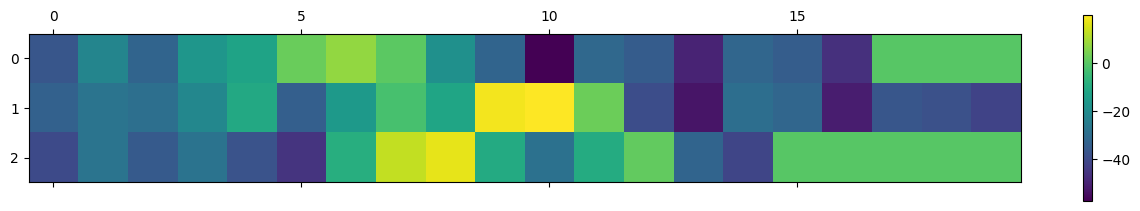

In [36]:
import requests
import json
from matplotlib import pyplot as plt

sequences = ["AACGGEVWVTDEAAAAA",
             "AAAAACGGGVWWTDEAAAAA",
             "AAAADGGVWVTECDA",]

url = "http://localhost:9999/v2/models/AMPLIFY/generate_stream"
headers = {"Content-Type": "application/json"}
response = requests.post(url, headers=headers, data=json.dumps({"sequences": sequences}))
if response.status_code == 200:
    response_dict = json.loads(response.text.split("data:")[1])
    embeddings = np.array(response_dict["embeddings"]).reshape(len(sequences), -1, 960)

    print(embeddings.shape)
    plt.matshow(embeddings[..., 0])
    plt.colorbar()

In [34]:
triton.stop()

2024-10-03 03:00:15,078 - WARNING - pytriton.server.triton_server: Triton Inference Server exited with failure. Please wait.


2024-10-03 03:00:15,103 - INFO - pytriton.proxy.inference: Closing Inference Handler


I1003 03:00:15.183640 401025 pb_stub.cc:2049]  Non-graceful termination detected. 
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked shared_memory objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


True